In [1]:
import os
import pandas as pd
import numpy as np
import json

import xgboost as xgb
import matplotlib
import matplotlib.pyplot  as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
import math
import time
from scipy import stats
from statannotations.Annotator import Annotator
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer


%matplotlib inline

## Data import

In [3]:
lycopene_data = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/IPP_only_normalized_yb.csv', index_col = 0)
label = lycopene_data['result']
lycopene_data.drop(columns = ['result'], inplace = True)
col_list = lycopene_data.columns.tolist()

In [4]:
def preprocess(df, label, col_list):
    df_processed = []
    label_processed = []
    for group in df.groupby(df.columns.tolist()):
        idx_list = group[-1].index.tolist() # group index info
        iter_num = len(idx_list)//3
        for i in range(iter_num+1):
            try :
                tmp = idx_list[i*3:(i+1)*3]
            except :
                tmp = idx_list[i*3:]
            if len(tmp) > 0:
                df_processed.append(group[-1].iloc[0,:])
                label_processed.append(np.mean(label[tmp]))
    df_processed = pd.DataFrame(np.stack(df_processed), columns = col_list)
    label_processed = pd.Series(label_processed)
    return df_processed, label_processed
def make_onehot(df):
    enz_c = df[['Idi','ispA','CrtE','CrtB','CrtI']]
    enz_amount = df[['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']]
    
    enz_onehot = []
    col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
    for _, row in enz_c.iterrows():
        tmp = []
        for idx, enz in enumerate(['Idi','ispA','CrtE','CrtB','CrtI']):
            if enz == 'Idi':
                onehot = [0]*4
                if int(row[enz]) < 1:
                    tmp.extend(onehot)
                else:
                    onehot[int(row[enz])-1] = 1
                    tmp.extend(onehot)
            else:
                onehot = [0]*5
                if int(row[enz]) == 0:
                    tmp.extend(onehot)
                else:
                    onehot[int(row[enz])-1] = 1
                    tmp.extend(onehot)
        enz_onehot.append(tmp)
    enz_onehot = pd.DataFrame(enz_onehot, columns = onehot_col_list )
    
    df_onehot = pd.concat([enz_onehot, enz_amount], axis = 1)
    return df_onehot

In [5]:
lycopene_processed, label_processed = preprocess(lycopene_data, label, col_list)

onehot_col_list = ['SlIdi', 'AtIdi', 'RcIdi', 'OgIdi',
                   'EcispA', 'KaispA', 'JcispA', 'SeispA', 'BaispA',
                   'PacrtE', 'KpcrtE', 'HpcrtE', 'NicrtE', 'ShcrtE',
                   'PacrtB', 'KpcrtB', 'LacrtB', 'RccrtB', 'SicrtB',
                   'PacrtI', 'ErcrtI', 'SscrtI', 'BvcrtI', 'LacrtI']
lycopene_processed_onehot = make_onehot(lycopene_processed)
lycopene_onehot = make_onehot(lycopene_data)

In [8]:
lycopene_onehot

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.10,0.25,0.25,0.25,0.25
1,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.25,0.25,0.25,0.25,0.25
2,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.50,0.25,0.25,0.25,0.25
3,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1.00,0.25,0.25,0.25,0.25
4,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.10,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.00,0.25,0.25,0.25,0.25
286,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0.25,0.00,0.25,0.25,0.25
287,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0.25,0.25,0.00,0.25,0.25
288,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0.25,0.25,0.25,0.00,0.25


In [103]:
random_test = pd.read_csv('/work/home/ybchae/active_learning/recommendation/random_test_set_result.csv')
random_label = random_test['result'].apply(lambda x: max(0, x))
random_test.drop(columns = ['result'], inplace = True)
random_test_processed, random_label_processed = preprocess(random_test, random_label, col_list)
random_test_processed_onehot = make_onehot(random_test_processed)

In [9]:
random_test_processed_onehot

,SlIdi,AtIdi,RcIdi,OgIdi,EcispA,KaispA,JcispA,SeispA,BaispA,PacrtE,...,PacrtI,ErcrtI,SscrtI,BvcrtI,LacrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0.10,0.50,0.50,0.25,0.25
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0.10,0.10,0.50,0.25,0.50
2,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0.10,0.25,1.00,0.25,0.10
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.10,1.00,0.50,0.10,0.25
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0.25,0.10,0.25,0.50,0.10
5,0,1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0.25,0.25,0.50,0.25,0.25
6,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0.25,1.00,1.00,0.50,0.25
7,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0.25,0.25,1.00,0.50,0.50
8,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0.50,1.00,0.25,0.50,0.50
9,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0.50,1.00,0.25,0.25,1.00


In [358]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
ispa_conc_list = [0,0.1,0.25,0.5,1] #ispa 가능한 농도
conc_list = [0.1,0.25,0.5, 1] # 가능한 농도

idi_enz_type = product([1,2,3,4], repeat = 1) #idi가능한 종류
enz_type = product([1,2,3,4,5], repeat = 4)

ispa_enz_conc = product(ispa_conc_list, repeat = 1)
enz_conc = product(conc_list, repeat = 4)

num = 0
ALL_possible_conditions = []
for i in tqdm(product(idi_enz_type,ispa_enz_conc,enz_type, enz_conc)):
    one_hot_encoded = np.zeros((1, 24))
    
    enz_type_tmp1 = np.array(i[0])
    enz_conc_tmp1 = np.array(i[1])
    enz_type_tmp2 = np.array(i[2])
    enz_conc_tmp2 = np.array(i[3])
    
    if enz_conc_tmp1[0] == 0: # ispA가 0
        enz_type_tmp2[0] = 0
    one_hot_encoded[0, enz_type_tmp1[0] -1] = 1 # IDI 인코딩
    for j, value in enumerate(enz_type_tmp2):
        if value > 0:
            one_hot_encoded[0, 4 + 5*j + value -1] = 1
    
    concat_tmp = np.concatenate((one_hot_encoded, enz_conc_tmp2[:1].reshape(1,-1), enz_conc_tmp1.reshape(1,-1), enz_conc_tmp2[1:].reshape(1,-1)), axis = 1)

    ALL_possible_conditions.append(concat_tmp)
    num += 1

ALL_possible_conditions = pd.DataFrame(np.squeeze(np.array(ALL_possible_conditions)), columns = col_list)
ALL_possible_conditions.drop_duplicates(inplace = True)
ALL_possible_conditions = ALL_possible_conditions.reset_index(drop = True)
print('Number of all possible experimental conditions : {}'.format(ALL_possible_conditions.shape[0]))

scaler = MinMaxScaler()
scaled_ALL_possible_conditions = scaler.fit_transform(ALL_possible_conditions)
scaled_X_train = scaler.transform(lycopene_processed_onehot)
scaled_X_test = scaler.transform(random_test_processed_onehot)

3200000it [00:53, 59355.99it/s] 


Number of all possible experimental conditions : 2688000


In [9]:
def transform_df(df):
    df_conc = df.iloc[:,-5:]
    df_type = []
    for idx, row in df.iterrows():
        row_type = row[:-5]
        type_tmp = row_type[row_type!=0].index.tolist()
        if len(type_tmp) != 5: #ispA가 0일경우
            type_tmp = type_tmp[:1] + ['none'] + type_tmp[1:]
        type_tmp_num = []
        for t in type_tmp:
            type_tmp_num.append(homolog_num_dict[t])
        df_type.append(type_tmp_num)
    df_type = pd.DataFrame(df_type, columns =['Idi', 'ispA', 'CrtE','CrtB','CrtI'])
    df_transformed = pd.concat([df_type, df_conc], axis = 1)
    return df_transformed

## RandomSearch

In [10]:
ensemble_len = 20
# Create the grid search parameter and scoring functions
param_grid = {
    "learning_rate": [0.01, 0.03, 0.1, 0.3],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "max_depth": [2, 3, 4, 6 ,8],
    "objective": ['reg:absoluteerror'],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.4, 0.6],
    "min_child_weight": [1, 2, 4],
    "random_state" : [42],
    "nthread" : [2]}

# create the grid search object

def optimize_param(x,y):
    model = XGBRegressor(n_estimators = 500)
    
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter= 1000,
        random_state = 42)
    grid.fit(x, y)
    grid_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    print(-1*np.mean(grid_results['mean_test_score'][:ensemble_len]))
    params_list = grid_results.params.iloc[0:ensemble_len,].tolist()
    return params_list, grid_results['mean_test_score'][:]

In [362]:
params_list, grid_results = optimize_param(scaled_X_train, label_processed)

0.34016989307686224


In [ ]:
day0_cv_total = []
for p in params_list:
    xgb_reg = XGBRegressor(**p, n_estimators = 500)
    cv_scores = cross_val_score(xgb_reg, scaled_X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    day0_cv_total.append(np.mean(cv_scores))
print(np.mean(day0_cv_total))

In [48]:
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day0_param.json', 'w') as f:
#     json.dump(params_list, f)

In [364]:
def test_func(p_list, x_train, x_test, y_train, y_test):
    test_mae = []
    test_pred_total = []
    d_train_onehot = xgb.DMatrix(x_train, y_train)
    d_test_onehot = xgb.DMatrix(x_test, y_test)
    for params in p_list :
        params['device'] = 'cuda:1'
        model = xgb.train(params, d_train_onehot, num_boost_round=500)
    
        test_pred = model.predict(d_test_onehot)
        test_pred_total.append(test_pred)
        mae = mean_absolute_error(y_test, test_pred)
        test_mae.append(mae)
    print('Test score : {}'.format(np.mean(test_mae)))
    return test_mae, test_pred_total

In [365]:
day0_mae, day0_pred  = test_func(params_list, scaled_X_train, scaled_X_test, label_processed, random_label_processed)
day0_r2 = []
for i in range(len(day0_pred)):
    day0_r2.append(r2_score(random_label_processed, day0_pred[i]))
print(np.mean(day0_r2))

Test score : 0.4758172092581335
0.08675846648848448


## Recommendation

In [12]:
exploration_param = {1: 1.41, 2: 1.41, 3: 1.41, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 0.5, 
                     9: 0.5, 10: 0.5 , 11: 0.5, 12: 0.5, 13: 0.5, 14: 0.5, 15: 0.5, 16: 0.5, 
                     17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5}
homolog_num_dict = {"none" : 0, "SlIdi":1, 'AtIdi':2, 'RcIdi':3, 'OgIdi':4,
                   'EcispA':1, 'KaispA':2, 'JcispA':3, 'SeispA':4, 'BaispA':5,
                   'PacrtE':1, 'KpcrtE':2, 'HpcrtE':3, 'NicrtE':4, 'ShcrtE':5,
                   'PacrtB':1, 'KpcrtB':2, 'LacrtB':3, 'RccrtB':4, 'SicrtB':5,
                   'PacrtI':1, 'ErcrtI':2, 'SscrtI':3, 'BvcrtI':4, 'LacrtI':5}
def METIS_recommendation(p_list, X_selected, y_selected, X_not_selected, day, mode = 'prediction'):
    pred = []
    test_mae = []
    test_mse = []
    test_r2 = []

    d_selected = xgb.DMatrix(X_selected, y_selected)
    d_not_selected = xgb.DMatrix(X_not_selected, np.zeros(X_not_selected.shape[0]))
    for param in p_list:
        param['device'] = 'cuda:0'
        param['nthread'] = 2

        model = xgb.train(param, d_selected, num_boost_round=500)
        temp = model.predict(d_not_selected)
        pred.append(temp)
    if mode == 'prediction':
        exploration = 1
        exploitation = 0
    elif mode == 'optimization':
        exploration = exploration_param[day]
        exploitation = 1
    print(exploration,exploitation) 
        
    ucb_score = exploration * np.stack(pred).std(axis = 0) + exploitation * np.stack(pred).mean(axis = 0)
    ucb_df = pd.DataFrame(ucb_score, columns = ['UCB'])

    next_round_idx = ucb_df.sort_values(by = 'UCB', ascending = False).index.tolist()[:sampling_num]
    idx_list = []
    for idx in ucb_df.sort_values(by = 'UCB', ascending = False).index.tolist():
        target_row = X_not_selected[idx]
        row_exists = np.any(np.all(X_selected == target_row, axis=1))
        if row_exists : 
            continue
        else:
            idx_list.append(idx)
        if len(idx_list) == sampling_num:
            break
    print(next_round_idx, idx_list)

    return X_not_selected[next_round_idx]

def HAL_recommendation(p_list, X_selected, y_selected, X_not_selected, day):
    pred = []
    test_mae = []
    test_mse = []
    test_r2 = []
    
    d_selected = xgb.DMatrix(X_selected, y_selected)
    d_not_selected = xgb.DMatrix(X_not_selected, np.zeros(X_not_selected.shape[0]))
    
    for param in p_list:
        param['device'] = 'cuda:0'
        param['nthread'] = 2

        model = xgb.train(param, d_selected, num_boost_round=500)
        temp = model.predict(d_not_selected)
        pred.append(temp)
        
    M_param = ((day)/round_num)/2
    M_I_param = 1 - M_param
    print(round(M_I_param,3), round(M_param, 3))
    
    u_score = np.stack(pred).std(axis = 0)
    normalized_u_score = u_score/max(u_score)
    
    for k in range(sampling_num):
        d_n = []
        for i in tqdm(range(X_not_selected.shape[0])):
            d_nm = [math.dist(sample,X_not_selected[i]) for sample in X_selected]
            d_n.append(np.min(d_nm))
        normalized_d_n = d_n/np.max(d_n)
        d_n_df = pd.DataFrame(M_param*normalized_u_score + M_I_param*normalized_d_n, columns = ['HAL_score']) #HAL score calculation
        idx = d_n_df.sort_values(by = 'HAL_score',ascending = False).index.tolist()[0]
        print(X_not_selected[idx].reshape(1,-1))
        X_selected = np.concatenate((X_selected,X_not_selected[idx].reshape(1,-1)), axis = 0)
        X_not_selected = np.delete(X_not_selected, idx, axis = 0)
        normalized_u_score = np.delete(normalized_u_score, idx, axis = 0)

    return X_selected[-sampling_num:]

#### Day 1 recommend

In [126]:
sampling_num = 10
round_num = 5
day = 1
METIS_next = METIS_recommendation(params_list, scaled_X_train, y_train, scaled_ALL_possible_conditions, day)
HAL_next = HAL_recommendation(params_list, scaled_X_train, y_train, scaled_ALL_possible_conditions, day)

1 0
1.41 1
0.9 0.1


100%|██████████| 2856000/2856000 [14:41<00:00, 3241.24it/s]


[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 1. 1. 1. 1.]]


100%|██████████| 2855999/2855999 [14:49<00:00, 3211.75it/s]


[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 0. 1. 1.]]


100%|██████████| 2855998/2855998 [15:01<00:00, 3166.95it/s]


[[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  1. 1. 1. 1. 1.]]


100%|██████████| 2855997/2855997 [18:38<00:00, 2553.95it/s]


[[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 1. 0. 1.]]


100%|██████████| 2855996/2855996 [16:42<00:00, 2848.24it/s]


[[0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  1.  0.1 0.  1.  0. ]]


100%|██████████| 2855995/2855995 [15:48<00:00, 3009.60it/s]


[[0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.1 1.  0.  1.  0. ]]


100%|██████████| 2855994/2855994 [15:49<00:00, 3006.40it/s]


[[0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.1 1.  1.  0.  1. ]]


100%|██████████| 2855993/2855993 [15:59<00:00, 2976.25it/s]


[[0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.1 1.  1.  0.  0. ]]


100%|██████████| 2855992/2855992 [16:07<00:00, 2952.18it/s]


[[0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.1 1.  0.  0.  1. ]]


100%|██████████| 2855991/2855991 [16:22<00:00, 2907.74it/s]


[[0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.25 0.1  0.   1.
  0.  ]]


In [ ]:
METIS_next_df = pd.DataFrame(scaler.inverse_transform(METIS_next), columns = col_list)
HAL_next_df = pd.DataFrame(scaler.inverse_transform(HAL_next), columns = col_list)

METIS_next_df_transformed = transform_df(METIS_next_df)
HAL_next_df_transformed = transform_df(HAL_next_df)

METIS_next_df_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1.csv', index = False)
HAL_next_df_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1.csv', index = False)

#### Day1

In [282]:
# load data
with open('/work/home/ybchae/active_learning/data/lycopene/param/day0_param.json', 'r') as f:
    params_list = json.load(f)

In [283]:
METIS_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day1_result.csv')
HAL_day1 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day1_result.csv')

METIS_day1_label = METIS_day1['result'].apply(lambda x: max(0, x))
METIS_day1.drop(columns = ['result'], inplace = True)

HAL_day1_label = HAL_day1['result'].apply(lambda x: max(0, x))
HAL_day1.drop(columns = ['result'], inplace = True)

col_list = METIS_day1.columns.tolist()

In [284]:
METIS_day1_processed, METIS_day1_label_processed = preprocess(METIS_day1, METIS_day1_label, col_list)
HAL_day1_processed, HAL_day1_label_processed = preprocess(HAL_day1, HAL_day1_label, col_list)

In [286]:
METIS_day1_processed_onehot = make_onehot(METIS_day1_processed)
HAL_day1_processed_onehot = make_onehot(HAL_day1_processed)

In [287]:
day0_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_x.csv')
day0_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/Day0_train_y.csv')

In [288]:
METIS_day1_X_train = pd.concat([day0_X_train, METIS_day1_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day1_y_train = pd.concat([day0_y_train['0'], METIS_day1_label_processed], axis = 0).reset_index(drop = True)

HAL_day1_X_train = pd.concat([day0_X_train, HAL_day1_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day1_y_train = pd.concat([day0_y_train['0'], HAL_day1_label_processed], axis = 0).reset_index(drop = True)

# METIS_day1_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_x.csv', index = False)
# METIS_day1_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_y.csv', index = False)

# HAL_day1_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_x.csv', index = False)
# HAL_day1_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_y.csv', index = False)

scaled_METIS_day1_X_train = scaler.transform(METIS_day1_X_train)
scaled_HAL_day1_X_train = scaler.transform(HAL_day1_X_train)

In [291]:
METIS_day1_params_list, METIS_day1_grid_results = optimize_param(scaled_METIS_day1_X_train, METIS_day1_y_train)
HAL_day1_params_list, HAL_day1_grid_results = optimize_param(scaled_HAL_day1_X_train, HAL_day1_y_train)

0.2216266291409006
0.2191170933649734


In [79]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_METIS_param.json', 'w') as f:
    json.dump(METIS_day1_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_HAL_param.json', 'w') as f:
    json.dump(HAL_day1_params_list, f)

1.2776908816368986 0.20910918698851105


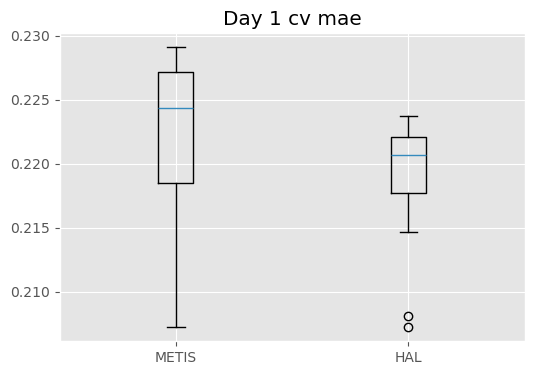

In [77]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day1_cv = [-1*METIS_day1_grid_results[:20], -1*HAL_day1_grid_results[:20]]
plt.boxplot(day1_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day1_grid_results[:20], -1*HAL_day1_grid_results[:20])
print(t, p_value)

In [80]:
METIS_day1_cv_total = []
HAL_day1_cv_total = []
for i in range(20):
    xgb_reg_METIS = XGBRegressor(**params_list[i], n_estimators = 500)
    xgb_reg_HAL = XGBRegressor(**params_list[i], n_estimators = 500)
    METIS_cv_scores = cross_val_score(xgb_reg_METIS, scaled_METIS_day1_X_train, METIS_day1_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    HAL_cv_scores = cross_val_score(xgb_reg_HAL, scaled_HAL_day1_X_train, HAL_day1_y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    METIS_day1_cv_total.append(np.mean(METIS_cv_scores))
    HAL_day1_cv_total.append(np.mean(HAL_cv_scores))
np.mean(METIS_day1_cv_total), np.mean(HAL_day1_cv_total)

/work/home/ybchae/anaconda3/envs/yb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:22:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


(0.2693380162646794, 0.25688030794112093)

In [292]:
METIS_day1_mae, METIS_day1_pred = test_func(METIS_day1_params_list, scaled_METIS_day1_X_train, scaled_X_test, METIS_day1_y_train, random_label_processed)
HAL_day1_mae, HAL_day1_pred = test_func(HAL_day1_params_list, scaled_HAL_day1_X_train, scaled_X_test, HAL_day1_y_train, random_label_processed)

Test score : 0.46767055441625516
Test score : 0.379551436910123


Text(0.5, 1.0, 'Day 1 test mae')

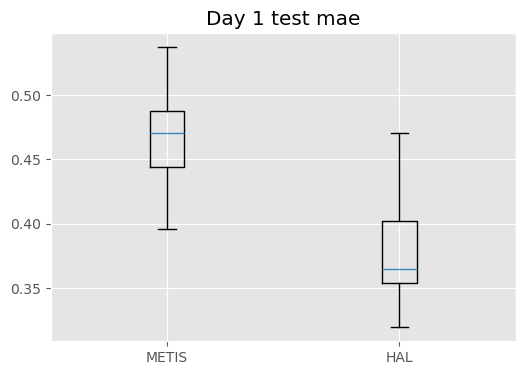

In [82]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')


x = np.arange(2)
day1_mae = [METIS_day1_mae, HAL_day1_mae]
plt.boxplot(day1_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 test mae")

In [83]:
METIS_day1_r2 = []
HAL_day1_r2 = []
for i in range(len(METIS_day1_pred)):
    METIS_day1_r2.append(r2_score(random_label_processed, METIS_day1_pred[i]))
    HAL_day1_r2.append(r2_score(random_label_processed, HAL_day1_pred[i]))
print(np.mean(METIS_day1_r2))
print(np.mean(HAL_day1_r2))

0.03871636256713936
0.45292122837304066


Text(0.5, 1.0, 'Day 1 R2')

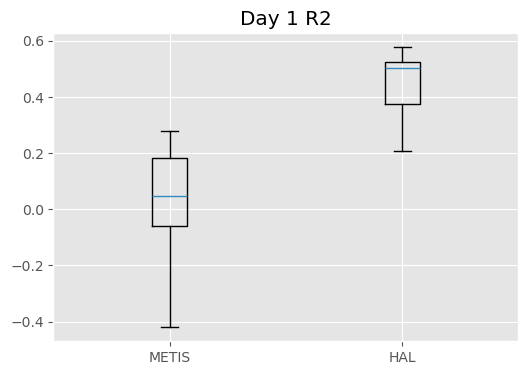

In [84]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day1_r2 = [METIS_day1_r2, HAL_day1_r2]
plt.boxplot(day1_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 1 R2")

#### Day2 recommend

In [72]:
sampling_num = 10
round_num = 5
day = 2
METIS_day2_recommend = METIS_recommendation(METIS_day1_params_list, scaled_METIS_day1_X_train, METIS_day1_y_train, scaled_ALL_possible_conditions, day)
HAL_day2_recommend = HAL_recommendation(HAL_day1_params_list, scaled_HAL_day1_X_train, HAL_day1_y_train, scaled_ALL_possible_conditions, day)

1 0
1.41 1
0.8 0.2


100%|██████████| 2856000/2856000 [22:44<00:00, 2092.49it/s]


[[0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.1 1.  1.  0.  1. ]]


100%|██████████| 2855999/2855999 [22:47<00:00, 2089.07it/s]


[[0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.5  0.25 1.   1.
  0.  ]]


100%|██████████| 2855998/2855998 [22:39<00:00, 2100.24it/s]


[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  1. 1. 1. 0. 1.]]


100%|██████████| 2855997/2855997 [23:24<00:00, 2033.18it/s]


[[0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.1 1.  0.  0. ]]


100%|██████████| 2855996/2855996 [23:37<00:00, 2015.34it/s]


[[0.         1.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         1.
  1.         0.5        1.         0.44444444 0.        ]]


100%|██████████| 2855995/2855995 [23:52<00:00, 1993.85it/s]


[[0.         0.         1.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         1.
  0.         0.         0.         1.         0.         0.
  0.25       0.1        0.16666667 1.         1.        ]]


100%|██████████| 2855994/2855994 [24:11<00:00, 1967.42it/s]


[[0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   1.   0.   1.   0.   0.   0.   0.1  0.25 1.   0.
  0.  ]]


100%|██████████| 2855993/2855993 [24:24<00:00, 1950.14it/s]


[[1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.1 1.  1.  1.  0. ]]


100%|██████████| 2855992/2855992 [24:49<00:00, 1917.96it/s]


[[0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.25 0.1  0.   0.
  1.  ]]


100%|██████████| 2855991/2855991 [24:58<00:00, 1906.18it/s]


[[0.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.
  0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.1  0.25 0.   0.
  0.  ]]


In [83]:
col_list = onehot_col_list + ['Idi_conc','ispA_conc','CrtE_conc','CrtB_conc','CrtI_conc']
METIS_day2_recommend_df = pd.DataFrame(scaler.inverse_transform(METIS_day2_recommend), columns = col_list)
HAL_day2_recommend_df = pd.DataFrame(scaler.inverse_transform(HAL_day2_recommend), columns = col_list)

METIS_day2_recommend_transformed = transform_df(METIS_day2_recommend_df)
HAL_day2_recommend_transformed = transform_df(HAL_day2_recommend_df)

In [103]:
METIS_day2_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,4,5,1,4,5,0.25,0.25,1.0,0.1,0.1
1,4,3,1,4,5,0.25,0.50,1.0,0.1,0.1
2,2,1,1,1,5,1.00,0.10,1.0,1.0,0.1
3,3,3,1,2,5,0.25,0.25,1.0,0.1,0.1
4,1,1,1,1,5,1.00,0.50,1.0,0.5,0.1
5,4,5,1,4,5,0.25,0.50,1.0,0.1,0.1
6,4,4,1,4,5,0.25,0.25,1.0,0.1,0.1
7,4,3,1,2,5,0.25,0.25,1.0,0.1,0.1
8,4,3,1,4,5,0.25,0.25,1.0,0.1,0.1
9,4,4,1,4,5,0.25,0.50,1.0,0.1,0.1


In [85]:
HAL_day2_recommend_transformed

,Idi,ispA,CrtE,CrtB,CrtI,Idi_conc,ispA_conc,CrtE_conc,CrtB_conc,CrtI_conc
0,3,2,3,5,4,0.10,1.00,1.00,0.1,1.0
1,2,4,4,3,4,0.50,0.25,1.00,1.0,0.1
2,1,4,3,3,3,1.00,1.00,1.00,0.1,1.0
3,3,5,5,2,4,1.00,0.10,1.00,0.1,0.1
4,2,2,3,2,5,1.00,0.50,1.00,0.5,0.1
5,3,4,4,4,3,0.25,0.10,0.25,1.0,1.0
6,4,4,3,5,2,0.10,0.25,1.00,0.1,0.1
7,1,5,3,2,2,0.10,1.00,1.00,1.0,0.1
8,2,5,3,4,4,0.25,0.10,0.10,0.1,1.0
9,4,2,4,2,3,0.10,0.25,0.10,0.1,0.1


In [101]:
METIS_day2_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2.csv', index = False)
HAL_day2_recommend_transformed[['Idi','Idi_conc','ispA','ispA_conc','CrtE','CrtE_conc','CrtB','CrtB_conc','CrtI','CrtI_conc']].to_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2.csv', index = False)

#### Day2

In [40]:
# load data
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_METIS_param.json', 'r') as f:
#     day1_METIS_params_list = json.load(f)
# with open('/work/home/ybchae/active_learning/data/lycopene/param/day1_HAL_param.json', 'r') as f:
#     day1_HAL_params_list = json.load(f)

In [296]:
METIS_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/METIS_pred_Day2_result.csv')
HAL_day2 = pd.read_csv('/work/home/ybchae/active_learning/recommendation/HAL_Day2_result.csv')

METIS_day2_label = METIS_day2['result'].apply(lambda x: max(0, x))
METIS_day2.drop(columns = ['result'], inplace = True)

HAL_day2_label = HAL_day2['result'].apply(lambda x: max(0, x))
HAL_day2.drop(columns = ['result'], inplace = True)

col_list = METIS_day2.columns.tolist()

In [297]:
METIS_day2_processed, METIS_day2_label_processed = preprocess(METIS_day2, METIS_day2_label, col_list)
HAL_day2_processed, HAL_day2_label_processed = preprocess(HAL_day2, HAL_day2_label, col_list)

METIS_day2_processed_onehot = make_onehot(METIS_day2_processed)
HAL_day2_processed_onehot = make_onehot(HAL_day2_processed)

In [300]:
METIS_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_x.csv')
METIS_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day1_train_y.csv')

HAL_day1_X_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_x.csv')
HAL_day1_y_train = pd.read_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day1_train_y.csv')

METIS_day2_X_train = pd.concat([METIS_day1_X_train, METIS_day2_processed_onehot], axis = 0).reset_index(drop = True)
METIS_day2_y_train = pd.concat([METIS_day1_y_train['0'], METIS_day2_label_processed], axis = 0).reset_index(drop = True)

HAL_day2_X_train = pd.concat([HAL_day1_X_train, HAL_day2_processed_onehot], axis = 0).reset_index(drop = True)
HAL_day2_y_train = pd.concat([HAL_day1_y_train['0'], HAL_day2_label_processed], axis = 0).reset_index(drop = True)

# METIS_day2_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_x.csv', index = False)
# METIS_day2_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/METIS_Day2_train_y.csv', index = False)

# HAL_day2_X_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_x.csv', index = False)
# HAL_day2_y_train.to_csv('/work/home/ybchae/active_learning/data/lycopene/HAL_Day2_train_y.csv', index = False)

scaled_METIS_day2_X_train = scaler.transform(METIS_day2_X_train)
scaled_HAL_day2_X_train = scaler.transform(HAL_day2_X_train)

In [303]:
METIS_day2_params_list, METIS_day2_grid_results = optimize_param(scaled_METIS_day2_X_train, METIS_day2_y_train)
HAL_day2_params_list, HAL_day2_grid_results = optimize_param(scaled_HAL_day2_X_train, HAL_day2_y_train)

0.24909155411787273
0.2857664194231483


-20.228531307069346 6.080601153973774e-22


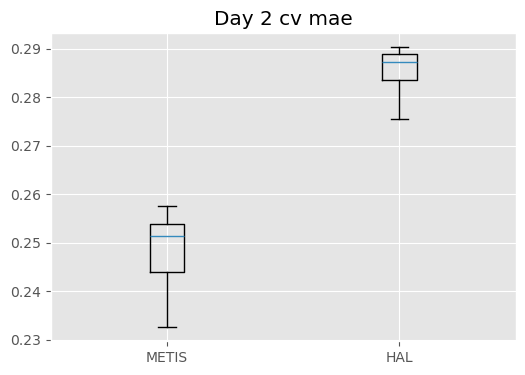

In [ ]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_cv = [-1*METIS_day2_grid_results[:20], -1*HAL_day2_grid_results[:20]]
plt.boxplot(day2_cv, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 cv mae")

t, p_value = stats.ttest_ind(-1*METIS_day2_grid_results[:20], -1*HAL_day2_grid_results[:20])
print(t, p_value)

In [ ]:
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_METIS_param.json', 'w') as f:
    json.dump(METIS_day2_params_list, f)
with open('/work/home/ybchae/active_learning/data/lycopene/param/day2_HAL_param.json', 'w') as f:
    json.dump(HAL_day2_params_list, f)

In [ ]:
METIS_day2_mae, METIS_day2_pred = test_func(METIS_day2_params_list, scaled_METIS_day2_X_train, scaled_X_test, METIS_day2_y_train, random_label_processed)
HAL_day2_mae, HAL_day2_pred = test_func(HAL_day2_params_list, scaled_HAL_day2_X_train, scaled_X_test, HAL_day2_y_train, random_label_processed)

Test score : 0.47247483078617625
Test score : 0.2917309701462952


11.633581756979062 4.33240140356528e-14


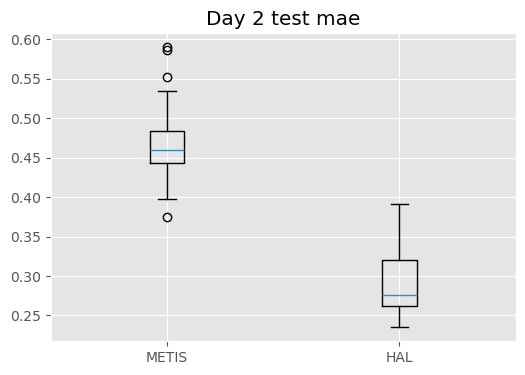

In [ ]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_mae = [METIS_day2_mae, HAL_day2_mae]
plt.boxplot(day2_mae, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 test mae")

t, p_value = stats.ttest_ind(METIS_day2_mae,HAL_day2_mae)
print(t, p_value)

In [ ]:
METIS_day2_r2 = []
HAL_day2_r2 = []
for i in range(len(METIS_day2_pred)):
    METIS_day2_r2.append(r2_score(random_label_processed, METIS_day2_pred[i]))
    HAL_day2_r2.append(r2_score(random_label_processed, HAL_day2_pred[i]))
print(np.mean(METIS_day2_r2))
print(np.mean(HAL_day2_r2))

0.035305392098026904
0.6416207689618233


-10.737317989587208 4.556871179306492e-13


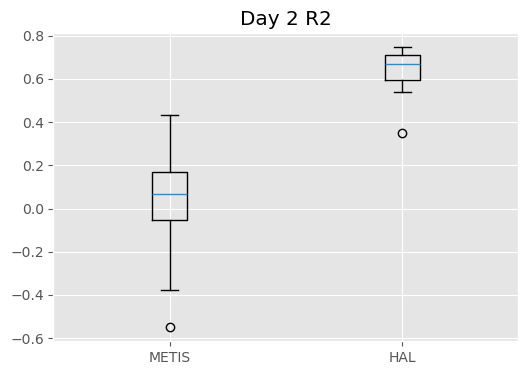

In [ ]:
plt.figure(figsize = (6,4))

plt.style.use('ggplot')

x = np.arange(2)
day2_r2 = [METIS_day2_r2, HAL_day2_r2]
plt.boxplot(day2_r2, positions = range(len(x)))
plt.xticks(x,['METIS', 'HAL'])
plt.title("Day 2 R2")

t, p_value = stats.ttest_ind(METIS_day2_r2,HAL_day2_r2)
print(t, p_value)